IMPORTS

In [14]:
import pandas as pd
import numpy as np
import torch
import lightning.pytorch as pl
import matplotlib.pyplot as plt


from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error


from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE
from pytorch_forecasting.models import RecurrentNetwork

LOAD DATA

In [15]:
INPUT_CSV = "C:/Users/User/Downloads/Master file.csv"

In [16]:
pl.seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ---------------- Config ----------------
INPUT_CSV = "C:/Users/User/Downloads/Master file.csv"
DATE_COL   = "Date"
GROUP_COL  = "RegionName"
HPI_LEVEL  = "Index"
TARGET_COL = "HPI_TRANS"

max_encoder_length    = 48   # same as TFT v1
max_prediction_length = 1

split_date = pd.Timestamp("2018-01-01")

# Same predictors you used for TFT v1 (no lags)
PREDICTOR_VARS = [
    "AWE_Regular",
    "UnemploymentRate",
    "CPI",
    "MortgageApprovals",
    "MortgageRate_2YFix",
    "BankRate",
    "ConsumerConfidence",
    "BM_New Housing",
    "gt_trend_buying_demand",
    "gt_trend_economic_policy",
    "gt_trend_market_awareness",
    "gt_trend_mortgage_financing",
    "gt_trend_renting_affordability",
    "AvgTone_Stitched",
]


Seed set to 42


Using device: cpu


In [17]:
print("Loading data from:", INPUT_CSV)
df = pd.read_csv(INPUT_CSV)

# Ensure datetime and sort
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values([GROUP_COL, DATE_COL]).reset_index(drop=True)

# Target: Δlog(HPI) by region
df[TARGET_COL] = (
    df.groupby(GROUP_COL)[HPI_LEVEL]
      .transform(lambda s: np.log(s).diff())
)

# Handle BM_New Housing missing (forward/backward fill within region)
if "BM_New Housing" in df.columns:
    df["BM_New Housing"] = (
        df.groupby(GROUP_COL)["BM_New Housing"]
          .transform(lambda s: s.ffill().bfill())
    )

# Drop rows with missing target
df = df.dropna(subset=[TARGET_COL]).reset_index(drop=True)

# Time index for LSTM/TFT
df = df.sort_values([GROUP_COL, DATE_COL])
df["time_idx"] = (
    (df[DATE_COL].dt.year - df[DATE_COL].dt.year.min()) * 12
    + (df[DATE_COL].dt.month - 1)
)

print("Data span:", df[DATE_COL].min(), "→", df[DATE_COL].max())
print("Regions:", df[GROUP_COL].nunique())

# Train / test split
df_train = df[df[DATE_COL] < split_date].copy()
df_test  = df[df[DATE_COL] >= split_date].copy()

print("Train shape:", df_train.shape)
print("Test shape :", df_test.shape)


Loading data from: C:/Users/User/Downloads/Master file.csv
Data span: 2005-02-01 00:00:00 → 2025-06-01 00:00:00
Regions: 405
Train shape: (62775, 25)
Test shape : (36450, 25)


In [18]:
max_train_time = df_train["time_idx"].max()
val_boundary   = max_train_time - 24
print("Validation boundary time_idx:", val_boundary)

continuous_features = PREDICTOR_VARS.copy()

# TRAIN dataset for LSTM: predictors as known, target as unknown
rnn_train_dataset = TimeSeriesDataSet(
    df_train[df_train.time_idx <= val_boundary],
    time_idx="time_idx",
    target=TARGET_COL,
    group_ids=[GROUP_COL],

    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,

    # 🔑 target is unknown
    time_varying_unknown_reals=[TARGET_COL],
    # 🔑 predictors are known for both encoder & decoder
    time_varying_known_reals=continuous_features,
    static_categoricals=[GROUP_COL],
)

# VALIDATION dataset
rnn_val_dataset = TimeSeriesDataSet.from_dataset(
    rnn_train_dataset,
    df_train,
    predict=True,
    stop_randomization=True,
)

# TEST dataset
rnn_test_dataset = TimeSeriesDataSet.from_dataset(
    rnn_train_dataset,
    df_test,
    predict=False,
    stop_randomization=True,
)

print("RNN Train samples:", len(rnn_train_dataset))
print("RNN Val samples  :", len(rnn_val_dataset))
print("RNN Test samples :", len(rnn_test_dataset))


Validation boundary time_idx: 131
RNN Train samples: 33615
RNN Val samples  : 405
RNN Test samples : 17010


In [19]:
batch_size = 128  # or 64 if needed

rnn_train_loader = rnn_train_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=0,
)

rnn_val_loader = rnn_val_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0,
)

rnn_test_loader = rnn_test_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    num_workers=0,
)

print("RNN Train batches:", len(rnn_train_loader))
print("RNN Val batches  :", len(rnn_val_loader))
print("RNN Test batches :", len(rnn_test_loader))


RNN Train batches: 262
RNN Val batches  : 4
RNN Test batches : 133


In [10]:


lstm = RecurrentNetwork.from_dataset(
    rnn_train_dataset,
    learning_rate=5e-4,
    hidden_size=64,
    rnn_layers=2,
    dropout=0.1,
    loss=RMSE(),
    output_size=1,
    reduce_on_plateau_patience=4,
)

print(f"LSTM parameters: {lstm.size()/1e3:.1f}k")


C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


LSTM parameters: 84.5k


In [21]:

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.callbacks import LearningRateMonitor

early_stop_lstm = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    mode="min",
    verbose=True,
)

lr_logger_lstm = LearningRateMonitor(logging_interval="epoch")

checkpoint_lstm = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True,
)

trainer_lstm = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    callbacks=[early_stop_lstm, lr_logger_lstm, checkpoint_lstm],
    gradient_clip_val=0.1,
    log_every_n_steps=50,
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [22]:
trainer_lstm.fit(
    lstm,
    train_dataloaders=rnn_train_loader,
    val_dataloaders=rnn_val_loader,
)

print("Best LSTM model path:", checkpoint_lstm.best_model_path)



  | Name             | Type           | Params | Mode 
------------------------------------------------------------
0 | loss             | RMSE           | 0      | train
1 | logging_metrics  | ModuleList     | 0      | train
2 | embeddings       | MultiEmbedding | 18.6 K | train
3 | rnn              | LSTM           | 65.8 K | train
4 | output_projector | Linear         | 65     | train
------------------------------------------------------------
84.5 K    Trainable params
0         Non-trainable params
84.5 K    Total params
0.338     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved. New best score: 0.014


Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.013


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.013


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.013


Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.013. Signaling Trainer to stop.


Best LSTM model path: C:\Users\User\Documents\Deep learning\lightning_logs\version_8\checkpoints\epoch=15-step=4192.ckpt


In [23]:
best_lstm = RecurrentNetwork.load_from_checkpoint(
    checkpoint_lstm.best_model_path
)

# Predict on test set with index to merge back
test_results = best_lstm.predict(test_loader, return_index=True)

y_pred = test_results.output.detach().cpu().numpy().flatten()
idx_df = test_results.index.copy()
idx_df["y_pred"] = y_pred

# Merge predictions back into df for evaluation
df_merged = df.merge(
    idx_df,
    on=[GROUP_COL, "time_idx"],
    how="inner",
)

df_eval = df_merged[df_merged[DATE_COL] >= split_date].copy()
df_eval["y_true"]   = df_eval[TARGET_COL]
df_eval["pct_true"] = df_eval["y_true"] * 100
df_eval["pct_pred"] = df_eval["y_pred"] * 100
df_eval["error"]    = df_eval["pct_pred"] - df_eval["pct_true"]

# ---- Panel metrics ----
rmse_panel = np.sqrt(mean_squared_error(df_eval["y_true"], df_eval["y_pred"]))
mae_panel  = mean_absolute_error(df_eval["y_true"], df_eval["y_pred"])

print("\n=== LSTM Panel (regional) performance ===")
print("RMSE (Δlog):", rmse_panel)
print("MAE  (Δlog):", mae_panel)
print("≈ RMSE (%):", rmse_panel * 100)
print("≈ MAE  (%):", mae_panel * 100)

# ---- UK aggregated metrics ----
df_uk = (
    df_eval.groupby(DATE_COL)
           .agg(
               uk_true=("pct_true", "mean"),
               uk_pred=("pct_pred", "mean"),
           )
           .reset_index()
)

rmse_uk = np.sqrt(mean_squared_error(df_uk["uk_true"], df_uk["uk_pred"]))
mae_uk  = mean_absolute_error(df_uk["uk_true"], df_uk["uk_pred"])

print("\n=== LSTM UK-aggregated performance ===")
print("UK RMSE (%):", rmse_uk)
print("UK MAE  (%):", mae_uk)


C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\utilities\parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
C:\Users\User\miniconda3\envs\tft_exp\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'predict_dataloader' does no


=== LSTM Panel (regional) performance ===
RMSE (Δlog): 0.028099482257345185
MAE  (Δlog): 0.022896523099376585
≈ RMSE (%): 2.8099482257345185
≈ MAE  (%): 2.2896523099376584

=== LSTM UK-aggregated performance ===
UK RMSE (%): 2.3078626676955523
UK MAE  (%): 2.2244688831661272


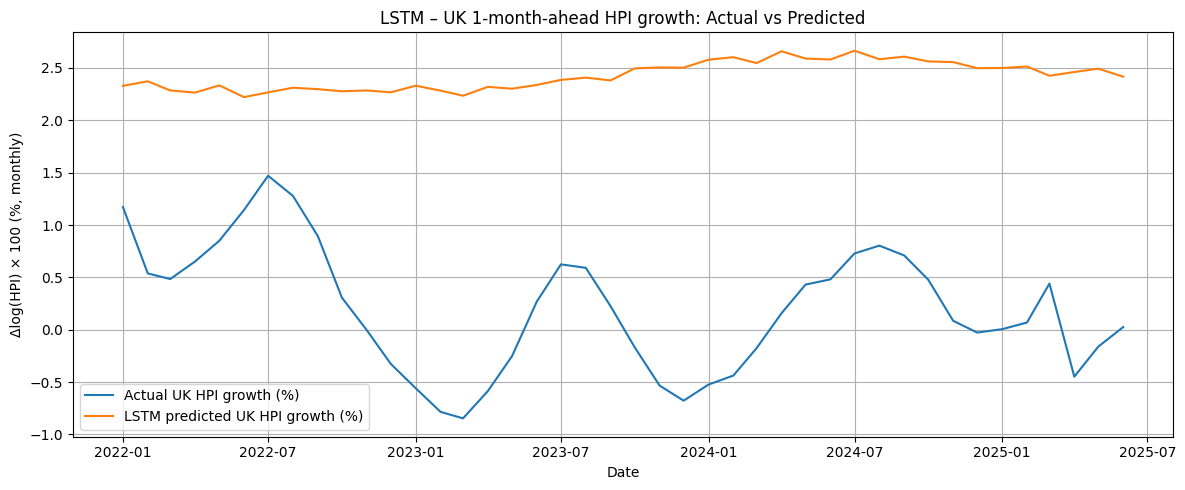

In [24]:


plt.figure(figsize=(12, 5))
plt.plot(df_uk["Date"], df_uk["uk_true"], label="Actual UK HPI growth (%)")
plt.plot(df_uk["Date"], df_uk["uk_pred"], label="LSTM predicted UK HPI growth (%)")
plt.title("LSTM – UK 1-month-ahead HPI growth: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Δlog(HPI) × 100 (%, monthly)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
